In [2]:
student_name = "Guangyao Li"
student_id = "45496919"

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import timedelta
plt.style.use('seaborn')
%matplotlib inline
import matplotlib.mlab as mlab
import seaborn as sb
from sklearn.linear_model import LinearRegression
import os

# Analysis of Cycling Data

## Loading Data

The first dataset is an export of my ride data from [Strava](https://strava.com/), an online social 
network site for cycling and other sports.  This data is a log of every ride since the start of 2018
and contains summary data like the distance and average speed.  It was exported using 
the script `stravaget.py` which uses the stravalib module to read data. Some details of
the fields exported by that script can be seen in [the documentation for stravalib](https://pythonhosted.org/stravalib/api.html#stravalib.model.Activity). 

The exported data is a CSV file so that's easy to read, however the date information in the file is 
recorded in a different timezone (UTC) so we need to do a bit of conversion.  In reading the data I'm
setting the index of the data frame to be the datetime of the ride. 

If the below cell gives error in `tz_localize`, use `tz_convert` as Pandas is time zone aware. 

In [41]:
stra = pd.read_csv('strava_export.csv', index_col='date', parse_dates=True)
stra.index = stra.index.tz_convert('UTC')
stra.head()

,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type
date,,,,,,,,,,
2018-01-02 20:47:51+00:00,100.6,21.0,73.8,False,15.2,94,316.00 m,10,73,Ride
2018-01-04 01:36:53+00:00,NaN,24.0,131.7,False,18.0,52,236.00 m,5,46,Ride
2018-01-04 02:56:00+00:00,83.1,25.0,13.8,False,0.0,3,0.00 m,2,2,Ride
2018-01-04 05:37:04+00:00,110.1,24.0,113.6,False,22.9,77,246.00 m,8,64,Ride
2018-01-05 19:22:46+00:00,110.9,20.0,147.7,True,58.4,189,676.00 m,12,144,Ride


The second dataset comes from an application called [GoldenCheetah](https://www.goldencheetah.org/) which provides
some analytics services over ride data.  This has some of the same fields but adds a lot of analysis of the 
power, speed and heart rate data in each ride.  This data overlaps with the Strava data but doesn't include all 
of the same rides. 

Again we create an index using the datetime for each ride, this time combining two columns in the data (date and time) 
and localising to Sydney so that the times match those for the Strava data. 

In [42]:
cheet = pd.read_csv('cheetah.csv', skipinitialspace=True)
cheet.index = pd.to_datetime(cheet['date'] + ' ' + cheet['time'])
cheet.index = cheet.index.tz_localize('Australia/Sydney')
cheet.head(10)

,date,time,filename,axPower,aPower Relative Intensity,aBikeScore,Skiba aVI,aPower Response Index,aIsoPower,aIF,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-28 06:39:49+11:00,01/28/18,06:39:49,2018_01_28_06_39_49.json,202.211,0.75452,16.6520,1.31920,1.67755,223.621,0.83441,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
2018-01-28 07:01:32+11:00,01/28/18,07:01:32,2018_01_28_07_01_32.json,226.039,0.84343,80.2669,1.21137,1.54250,246.185,0.91860,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-02-01 08:13:34+11:00,02/01/18,08:13:34,2018_02_01_08_13_34.json,0.000,0.00000,0.0000,0.00000,0.00000,0.000,0.00000,...,0,0,0,0,0,0,0,0.000,0.00000,0.0000
2018-02-06 08:06:42+11:00,02/06/18,08:06:42,2018_02_06_08_06_42.json,221.672,0.82714,78.8866,1.35775,1.86002,254.409,0.94929,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
2018-02-07 17:59:05+11:00,02/07/18,17:59:05,2018_02_07_17_59_05.json,218.211,0.81422,159.4590,1.47188,1.74658,233.780,0.87231,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780
2018-02-10 06:18:03+11:00,02/10/18,06:18:03,2018_02_10_06_18_03.json,189.918,0.70865,125.8670,1.31962,1.54810,212.977,0.79469,...,0,0,0,0,0,0,0,212.726,0.79375,147.7970
2018-02-11 07:21:37+11:00,02/11/18,07:21:37,2018_02_11_07_21_37.json,166.737,0.62215,12.4939,1.24269,1.60488,192.338,0.71768,...,0,0,0,0,0,0,0,192.117,0.71685,15.7590
2018-02-11 07:46:02+11:00,02/11/18,07:46:02,2018_02_11_07_46_02.json,227.134,0.84751,59.7968,1.14548,1.49494,244.770,0.91332,...,0,0,0,0,0,0,0,244.500,0.91231,69.2902
2018-02-13 08:19:36+11:00,02/13/18,08:19:36,2018_02_13_08_19_36.json,0.000,0.00000,0.0000,0.00000,0.00000,0.000,0.00000,...,0,0,0,0,0,0,0,0.000,0.00000,0.0000
2018-02-15 07:07:12+11:00,02/15/18,07:07:12,2018_02_15_07_07_12.json,208.745,0.77890,143.8520,1.42820,1.67028,224.096,0.83618,...,0,0,0,0,0,0,0,222.957,0.83193,155.9740


The GoldenCheetah data contains many many variables (columns) and we won't go into all of them here. Some
that are of particular interest for the analysis below are:

Here are definitions of some of the more important fields in the data. Capitalised fields come from the GoldenCheetah data
while lowercase_fields come from Strava. There are many cases where fields are duplicated and in this case the values
should be the same, although there is room for variation as the algorithm used to calculate them could be different
in each case. 

  * Duration - overall duration of the ride, should be same as elapsed_time
  * Time Moving - time spent moving (not resting or waiting at lights), should be the same as moving_time
  * Elevation Gain - metres climbed over the ride
  * Average Speed - over the ride
  * Average Power - average power in watts as measured by a power meter, relates to how much effort is being put in to the ride, should be the same as  * average_watts' from Strava
  * Nonzero Average Power - same as Average Power but excludes times when power is zero from the average
  * Average Heart Rate - should be the same as average_heartrate
  * Average Cadence - cadence is the rotations per minute of the pedals
  * Average Temp - temperature in the environment as measured by the bike computer (should be same as average_temp)
  * VAM - average ascent speed - speed up hills
  * Calories (HR) - Calorie expendature as estimated from heart rate data
  * 1 sec Peak Power - this and other  'Peak Power' measures give the maximum power output in the ride over this time period.  Will be higher for shorter periods. High values in short periods would come from a very 'punchy' ride with sprints for example.
  * 1 min Peak Hr - a similar measure relating to Heart Rate
  * NP - Normalised Power, a smoothed average power measurement, generally higher than Average Power 
  * TSS - Training Stress Score, a measure of how hard a ride this was
  * device_watts - True if the power (watts) measures were from a power meter, False if they were estimated
  * distance - distance travelled in Km
  * kudos - likes from other Strava users (social network)
  * workout_type - one of  'Race',  'Workout' or  'Ride'
  
  
Some of the GoldenCheetah parameters are defined [in thier documentation](https://github.com/GoldenCheetah/GoldenCheetah/wiki/UG_Glossary).  

## Your Tasks

Your first task is to combine these two data frames using the [`join` method of Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#joining-on-index).   The goal is to keep only those rows of data 
that appear in __both__ data frames so that we have complete data for every row.  

In [147]:
#Combine two data
df_join = stra.join(cheet,how='inner')
df_join.head(100)



,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-27 19:39:49+00:00,120.6,21.0,153.4,True,7.6,17,95.00 m,4,17,Ride,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
2018-01-27 20:01:32+00:00,146.9,22.0,187.7,True,38.6,67,449.00 m,19,67,Race,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-01-31 21:13:34+00:00,109.8,19.0,143.0,False,26.3,649,612.00 m,6,113,Ride,...,0,0,0,0,0,0,0,0.000,0.00000,0.0000
2018-02-05 21:06:42+00:00,119.3,19.0,165.9,True,24.3,69,439.00 m,6,65,Ride,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
2018-02-07 06:59:05+00:00,124.8,20.0,151.0,True,47.1,144,890.00 m,10,134,Ride,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-05 20:02:20+00:00,110.8,NaN,178.3,True,11.8,27,0.00 m,3,27,Ride,...,0,0,0,0,0,0,0,223.192,0.83281,31.7499
2018-11-06 06:59:59+00:00,103.3,NaN,110.8,False,20.7,74,301.80 m,19,69,Ride,...,0,0,0,0,0,0,0,0.000,0.00000,0.0000
2018-11-07 21:26:51+00:00,106.9,15.0,122.7,True,9.2,32,202.00 m,5,30,Ride,...,0,0,0,0,0,0,0,215.507,0.80413,33.1756
2018-11-08 06:39:34+00:00,128.3,13.0,174.3,True,46.6,146,923.00 m,11,127,Ride,...,0,0,0,0,0,0,0,249.459,0.93082,187.1710


## Required Analysis

1. Remove rides with no measured power (where device_watts is False) - these are commutes or MTB rides
* Look at the distributions of some key variables: time, distance, average speed, average power, TSS. Are they normally distributed? Skewed? 
* Explore the relationships between the following variables. Are any of them corrolated with each other (do they vary together in a predictable way)? Can you explain any relationships you observe?  
    * Distance
    * Moving Time
    * Average Speed
    * Heart Rate
    * Power (watts)
    * Normalised power (NP)
    * Training Stress Score
    * Elevation Gain
* We want to explore the differences between the three categories: `Race`, `Workout` and `Ride`.
    * Use scatter plots with different colours for each category to explore how these categories differ.  
    * Use histograms or box plots to visualise the different distributions of a variable for the three categories.
    * In both cases, experiment with different variables but only include those that are interesting in your final notebook (if none are interesting, show us a representative example).
* We want to explore relationship between `rides` and `weather`. In order to carry out this analysis, you need `weather` data from relevant source. For your convenience, we have downloaded temperature data from [Bureau of Meterology](http://www.bom.gov.au/). You can find temperature under `Maximum temperature (Degree C)` column which represents maximum temperature for the day. Under the `data` directory, you get `weather_data_2018.csv` and `weather_data_2019.csv` files from where you can read daily temperatures. In order to get temperature for a day so that you can use in your combined dataframe (joining Strava and Cheetah datasets), you need to make `date` column consistent in both dataframes. 
    * Make `date` column consistent across both `weather` and `rides` datasets so that you can get `Maximum temperature` for the day of the ride. 
    * Can you find any relationship between distance travelled per ride and the temperature?
    * Can you find any relatioship between Average speed of ride and the temperature?


## Challenge

* What leads to more `kudos`? Is there anything to indicate which rides are more popular? Explore the relationship between the main variables and kudos. Show a plot and comment on any relationship you observe. 

* Generate a plot that summarises the number of km ridden each month over the period of the data. Overlay this with the _sum_ of the Training Stress Score and the _average_ of the Average Speed to generate an overall summary of activity.

* Generate a similar graph but one that shows the activity over a given month, with the sum of the values for each day of the month shown.  So, if there are two rides on a given day, the graph should show the sum of the distances etc for these rides.

Hint: to generate these summary plots you need to use the [timeseries/date functionality](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) in Pandas to generate a new data frame containing the required data.  

__Note:__ once you have completed these steps you can remove this cell.  Use the text as a starting point for the documentation of your workflow and discussion of results.


# 1. Remove no measured power

In [157]:
#Remove 'device_watts'
df =df_join.drop(df_join.index[(df_join['device_watts'] ==False)])#set the condition
df.head(100)




,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-27 19:39:49+00:00,120.6,21.0,153.4,True,7.6,17,95.00 m,4,17,Ride,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
2018-01-27 20:01:32+00:00,146.9,22.0,187.7,True,38.6,67,449.00 m,19,67,Race,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-02-05 21:06:42+00:00,119.3,19.0,165.9,True,24.3,69,439.00 m,6,65,Ride,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
2018-02-07 06:59:05+00:00,124.8,20.0,151.0,True,47.1,144,890.00 m,10,134,Ride,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780
2018-02-09 19:18:03+00:00,123.0,20.0,145.9,True,59.8,193,656.00 m,22,139,Ride,...,0,0,0,0,0,0,0,212.726,0.79375,147.7970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-08 20:01:56+00:00,147.4,18.0,192.1,True,38.6,63,441.00 m,17,63,Race,...,0,0,0,0,0,0,0,245.859,0.91739,89.5832
2018-12-10 19:35:21+00:00,120.1,NaN,189.9,True,11.4,28,0.00 m,3,28,Workout,...,0,0,0,0,0,0,0,235.151,0.87743,36.9757
2018-12-12 19:20:20+00:00,131.9,NaN,176.9,True,25.7,61,0.00 m,7,61,Workout,...,0,0,0,0,0,0,0,225.961,0.84314,72.6284
2018-12-14 19:20:22+00:00,119.1,21.0,140.6,True,63.4,210,589.00 m,14,157,Ride,...,0,0,0,0,0,0,0,211.821,0.79038,164.0690


In [150]:
df.columns

Index(['average_heartrate', 'average_temp', 'average_watts', 'device_watts',
       'distance', 'elapsed_time', 'elevation_gain', 'kudos', 'moving_time',
       'workout_type',
       ...
       'Rest AVNN', 'Rest SDNN', 'Rest rMSSD', 'Rest PNN50', 'Rest LF',
       'Rest HF', 'HRV Recovery Points', 'NP', 'IF', 'TSS'],
      dtype='object', length=372)

# 2. Given variables' distribution

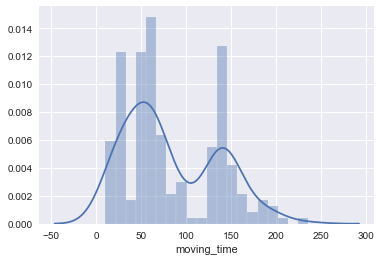

In [151]:
#moving_time plot
sb.distplot(df['moving_time'], bins=20)

The moving time shows a general right skewed distribution 

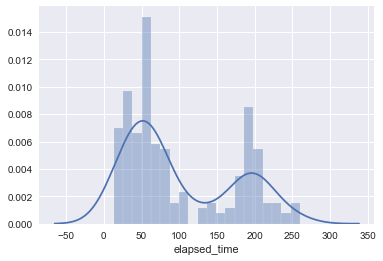

In [152]:
#elapsed_time plot
sb.distplot(df['elapsed_time'], bins = 20)

The elapsed_time shows a general right skewed distribution

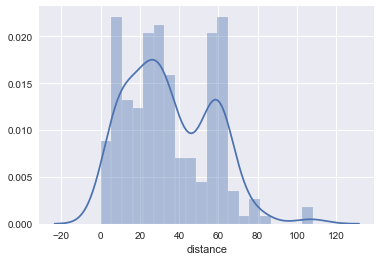

In [153]:
#distance plot
sb.distplot(df['distance'], bins=20)

The distance shows a right skewed distribution

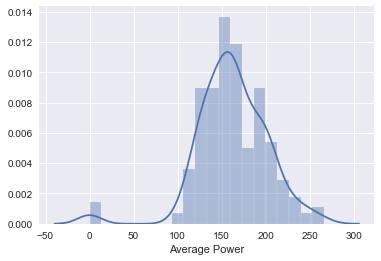

In [154]:
#Average Power plot
sb.distplot(df['Average Power'],bins=20)

Average Power shows a normal distribution

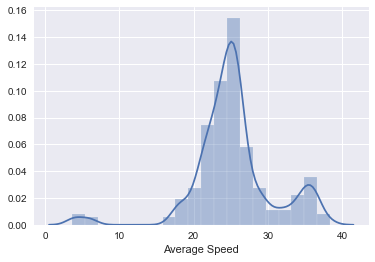

In [155]:
#Average Speed plot
sb.distplot(df['Average Speed'],bins=20)

Average Speed shows a normal distribution

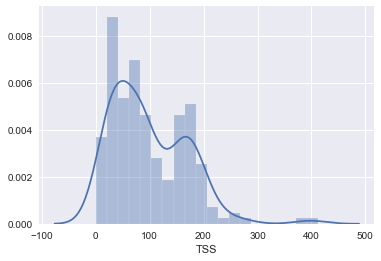

In [156]:
#TSS plot
sb.distplot(df['TSS'],bins=20)

The TSS shows a right skewed

# 3. Explore the relationships

In [52]:
#grab all factors
cf = df[['distance','Time Moving','Average Speed','NP','Elevation Gain','Average Heart Rate','TSS','Average Power']]
#correlate these variables
cf.corr()

,distance,Time Moving,Average Speed,NP,Elevation Gain,Average Heart Rate,TSS,Average Power
distance,1.000000,0.933596,0.187363,0.270703,0.805468,0.175241,0.922565,0.129199
Time Moving,0.933596,1.000000,-0.112951,0.034142,0.811409,0.039877,0.866093,-0.119617
Average Speed,0.187363,-0.112951,1.000000,0.674857,-0.016160,0.422165,0.134054,0.814403
NP,0.270703,0.034142,0.674857,1.000000,0.229933,0.343179,0.432286,0.844487
Elevation Gain,0.805468,0.811409,-0.016160,0.229933,1.000000,0.050890,0.828928,-0.035987
Average Heart Rate,0.175241,0.039877,0.422165,0.343179,0.050890,1.000000,0.183747,0.448912
TSS,0.922565,0.866093,0.134054,0.432286,0.828928,0.183747,1.000000,0.225290
Average Power,0.129199,-0.119617,0.814403,0.844487,-0.035987,0.448912,0.225290,1.000000


In [51]:
#Set as Whitegrid
sb.set(style="whitegrid",color_codes=True)

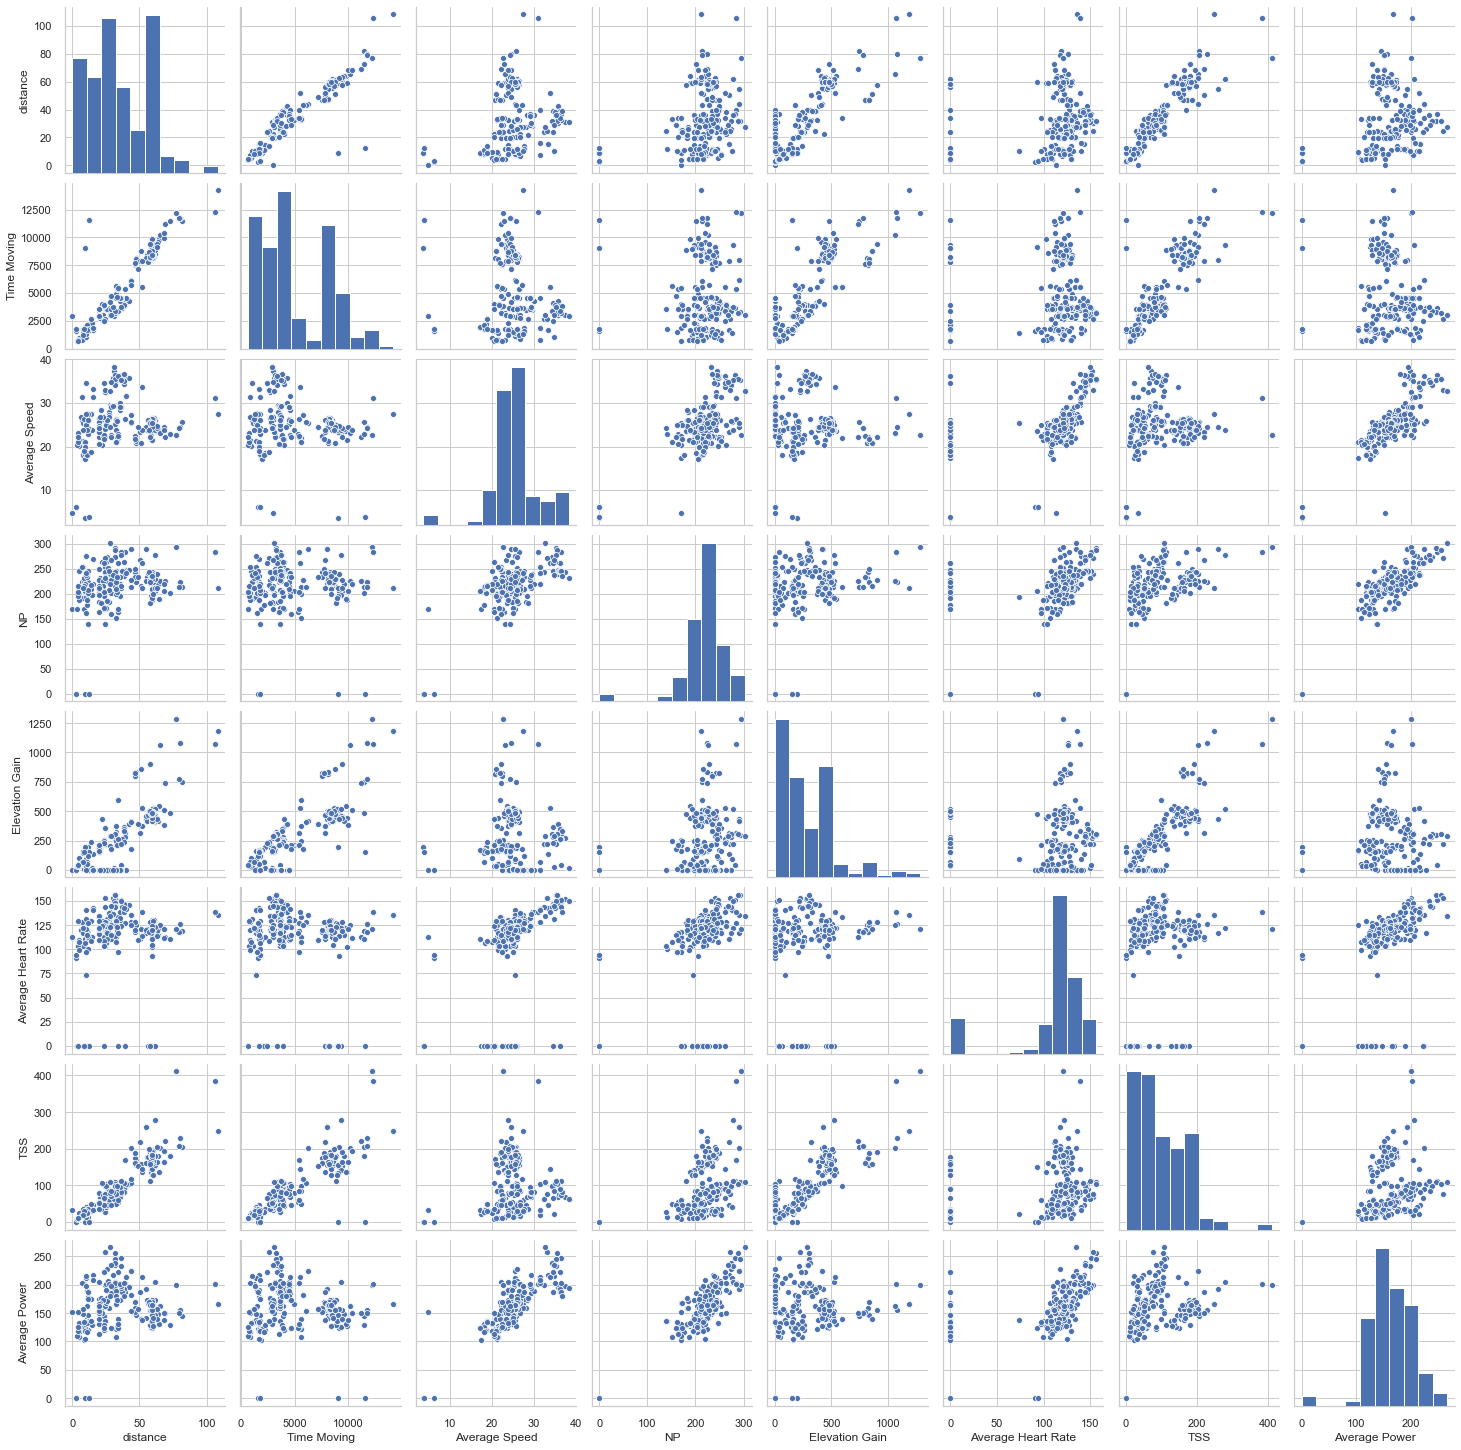

In [50]:
#Show the pairplot
pairplot=sb.pairplot(cf)

The above graph shows that there are some correlations between these variables. Especially, the relationship between the TSS and the Time Moving, Average speed and Average power, NP and Average Power, Average Heart rate and Average Power, etc looks like having a roughly correlations

In [61]:
#create a linear model of Time Moving and TSS
from sklearn import linear_model
reg = linear_model.LinearRegression()
X = cf[['Time Moving']]
y = cf['TSS']
#train the model
reg.fit(X, y)
print("y = x *", reg.coef_, "+", reg.intercept_)

y = x * [0.01929097] + 0.9328321157055512


In [63]:
#predict the value of TSS from some values of Time moving
reg.predict(X[:5])

array([ 21.24622132,  79.29274375,  77.0357005 , 158.32783926,
       163.26632704])

In [62]:
# check actual values
y[:5]

2018-01-27 19:39:49+00:00     20.2257
2018-01-27 20:01:32+00:00     94.5787
2018-02-05 21:06:42+00:00     98.3269
2018-02-07 06:59:05+00:00    171.0780
2018-02-09 19:18:03+00:00    147.7970
Name: TSS, dtype: float64

We can see that model predicted values close to the observe values by comparing ground truth values of y with the predicted values.

In [71]:
# Check how well does this model fit by using R2
from sklearn.metrics import r2_score
predicted = reg.predict(X)
r2 = r2_score(y, predicted)
print("R Squared:", r2)


R Squared: 0.7501164360332752


Not bad fit! So the relationship between TSS and Time Moving is a positive correlations.
 Adding TSS as a feature to Time Moving improving our model.

# 4. Explore the differences

In [73]:
#Setup category 'Race' data
pick_color1=df[(df['workout_type']=='Race')]
pick_color1.head()

,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-27 20:01:32+00:00,146.9,22.0,187.7,True,38.6,67,449.00 m,19,67,Race,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-02-10 20:46:02+00:00,152.1,19.0,198.9,True,31.0,49,387.00 m,21,49,Race,...,0,0,0,0,0,0,0,244.500,0.91231,69.2902
2018-03-03 20:02:23+00:00,143.0,18.0,217.3,True,15.5,32,175.00 m,15,28,Race,...,0,0,0,0,0,0,0,270.462,1.00919,47.6412
2018-03-24 20:45:44+00:00,153.6,16.0,200.2,True,30.1,50,381.00 m,16,50,Race,...,0,0,0,0,0,0,0,240.085,0.89584,67.9698
2018-04-07 21:47:39+00:00,141.8,17.0,223.7,True,10.0,23,130.00 m,11,22,Race,...,0,0,0,0,0,0,0,275.057,1.02633,41.5492


In [74]:
#Setup category 'Ride' data
pick_color2=df[(df['workout_type']=='Ride')]
pick_color2.head()

,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-27 19:39:49+00:00,120.6,21.0,153.4,True,7.6,17,95.00 m,4,17,Ride,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
2018-02-05 21:06:42+00:00,119.3,19.0,165.9,True,24.3,69,439.00 m,6,65,Ride,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
2018-02-07 06:59:05+00:00,124.8,20.0,151.0,True,47.1,144,890.00 m,10,134,Ride,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780
2018-02-09 19:18:03+00:00,123.0,20.0,145.9,True,59.8,193,656.00 m,22,139,Ride,...,0,0,0,0,0,0,0,212.726,0.79375,147.7970
2018-02-10 20:21:37+00:00,103.9,17.0,134.9,True,7.8,19,92.00 m,8,18,Ride,...,0,0,0,0,0,0,0,192.117,0.71685,15.7590


In [75]:
#Setup category 'Workout' data
pick_color3=df[(df['workout_type']=='Workout')]
pick_color3.head()

,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-05-13 20:44:30+00:00,114.8,14.0,164.2,True,0.0,52,0.00 m,9,52,Workout,...,0,0,0,0,0,0,0,169.042,0.63075,33.3201
2018-05-21 20:34:30+00:00,138.5,11.0,188.2,True,28.3,59,0.00 m,8,59,Workout,...,0,0,0,0,0,0,0,239.275,0.89282,76.5235
2018-05-28 20:47:42+00:00,135.4,10.0,185.6,True,28.9,60,0.00 m,7,60,Workout,...,0,0,0,0,0,0,0,223.167,0.83271,68.4551
2018-06-04 20:50:03+00:00,139.3,11.0,191.1,True,35.8,73,0.00 m,11,73,Workout,...,0,0,0,0,0,0,0,220.407,0.82242,80.7883
2018-08-01 20:41:09+00:00,125.0,10.0,161.0,True,22.0,52,0.00 m,6,52,Workout,...,0,0,0,0,0,0,0,182.578,0.68126,39.0891


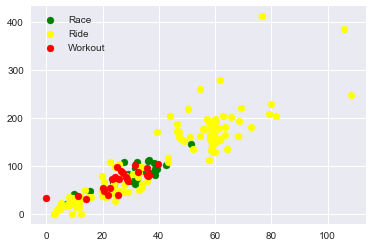

In [83]:
#See difference among there categories in terms of the correlation between distance and TSS
plt.scatter(pick_color1["distance"],pick_color1["TSS"],color='green', label="Race")
plt.scatter(pick_color2["distance"],pick_color2["TSS"],color='yellow', label="Ride")
plt.scatter(pick_color3["distance"],pick_color3["TSS"],color='red',label="Workout")
plt.legend()
plt.show()

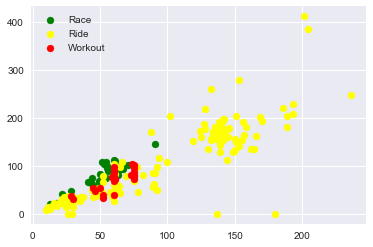

In [89]:
#See difference among there categories in terms of the correlation between moving time and TSS
plt.scatter(pick_color1["moving_time"],pick_color1["TSS"],color='green', label="Race")
plt.scatter(pick_color2["moving_time"],pick_color2["TSS"],color='yellow', label="Ride")
plt.scatter(pick_color3["moving_time"],pick_color3["TSS"],color='red',label="Workout")
plt.legend()
plt.show()

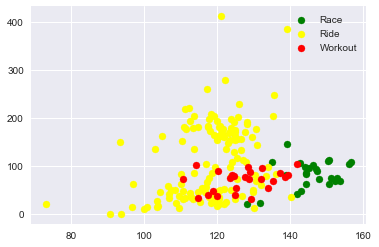

In [86]:
#See difference among there categories in terms of the correlation between average heartrate and TSS
plt.scatter(pick_color1["average_heartrate"],pick_color1["TSS"],color='green', label="Race")
plt.scatter(pick_color2["average_heartrate"],pick_color2["TSS"],color='yellow', label="Ride")
plt.scatter(pick_color3["average_heartrate"],pick_color3["TSS"],color='red',label="Workout")
plt.legend()
plt.show()

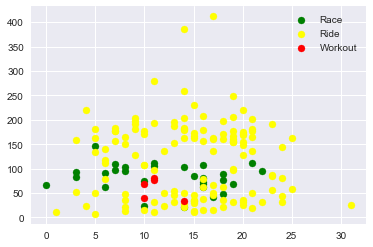

In [87]:
#See difference among there categories in terms of the correlation between average temperature and TSS
plt.scatter(pick_color1["average_temp"],pick_color1["TSS"],color='green', label="Race")
plt.scatter(pick_color2["average_temp"],pick_color2["TSS"],color='yellow', label="Ride")
plt.scatter(pick_color3["average_temp"],pick_color3["TSS"],color='red',label="Workout")
plt.legend()
plt.show()

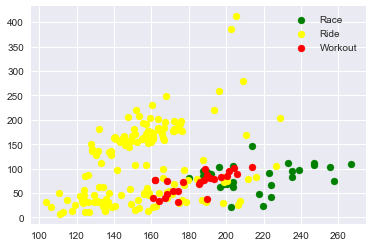

In [88]:
#See difference among there categories in terms of the correlation between average watts and TSS
plt.scatter(pick_color1["average_watts"],pick_color1["TSS"],color='green', label="Race")
plt.scatter(pick_color2["average_watts"],pick_color2["TSS"],color='yellow', label="Ride")
plt.scatter(pick_color3["average_watts"],pick_color3["TSS"],color='red',label="Workout")
plt.legend()
plt.show()


As these scattar above shows that the distance, moving time, average heartrate and average watts are highly correlated with TSS among there categories, and there is no relationship between the average temperature and TSS within three categories

Boxplot analysis

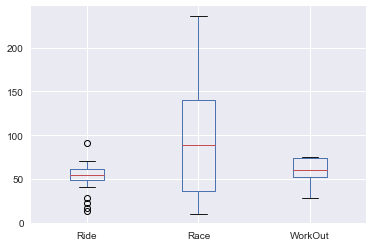

In [99]:
#Boxplot among three categories in terms of Moving time
box2=pd.concat([pick_color1['moving_time'],pick_color2['moving_time'],pick_color3['moving_time']], axis=1, keys=['Ride', 'Race','WorkOut'])
box2.boxplot()
plt.show()

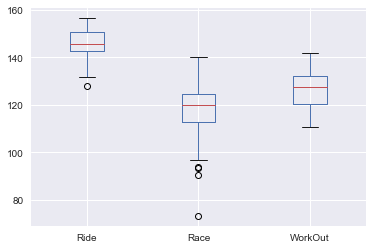

In [159]:
#Boxplot among three categories in terms of average_heartrate
box3=pd.concat([pick_color1['average_heartrate'],pick_color2['average_heartrate'],pick_color3['average_heartrate']], axis=1, keys=['Ride', 'Race','WorkOut'])
box3.boxplot()
plt.show()

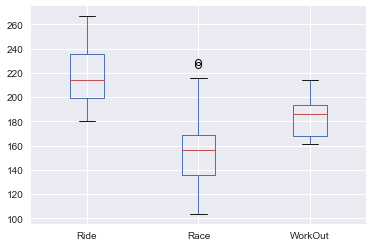

In [158]:
#Boxplot among three categories in terms of average_watts
box3=pd.concat([pick_color1['average_watts'],pick_color2['average_watts'],pick_color3['average_watts']], axis=1, keys=['Ride', 'Race','WorkOut'])
box3.boxplot()
plt.show()

As we can see, Race has lowest median in average watts and average heartrate.But in moving time it has the highest median. While for riding, it has the highest median among three categories.

# 5.

In [4]:
#data 2018
weather_2018 = pd.read_csv('weather_data_2018.csv')
weather_2018.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
0,IDCJAC0010,66212,2018,1,1,30.9,1.0,Y
1,IDCJAC0010,66212,2018,1,2,28.8,1.0,Y
2,IDCJAC0010,66212,2018,1,3,25.3,1.0,Y
3,IDCJAC0010,66212,2018,1,4,25.4,1.0,Y
4,IDCJAC0010,66212,2018,1,5,28.9,1.0,Y


In [5]:
#data2019
weather_2019 = pd.read_csv('weather_data_2019.csv')
weather_2019.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
0,IDCJAC0010,66212,2019,1,1,34.0,1.0,Y
1,IDCJAC0010,66212,2019,1,2,30.6,1.0,Y
2,IDCJAC0010,66212,2019,1,3,28.9,1.0,Y
3,IDCJAC0010,66212,2019,1,4,33.7,1.0,Y
4,IDCJAC0010,66212,2019,1,5,39.3,1.0,Y


In [6]:
#join data
weatherCombine = pd.merge(weather_2018, weather_2019, left_index=True, right_index=True, how='outer')
weatherCombine.head()

,Product code_x,Bureau of Meteorology station number_x,Year_x,Month_x,Day_x,Maximum temperature (Degree C)_x,Days of accumulation of maximum temperature_x,Quality_x,Product code_y,Bureau of Meteorology station number_y,Year_y,Month_y,Day_y,Maximum temperature (Degree C)_y,Days of accumulation of maximum temperature_y,Quality_y
0,IDCJAC0010,66212,2018,1,1,30.9,1.0,Y,IDCJAC0010,66212,2019,1,1,34.0,1.0,Y
1,IDCJAC0010,66212,2018,1,2,28.8,1.0,Y,IDCJAC0010,66212,2019,1,2,30.6,1.0,Y
2,IDCJAC0010,66212,2018,1,3,25.3,1.0,Y,IDCJAC0010,66212,2019,1,3,28.9,1.0,Y
3,IDCJAC0010,66212,2018,1,4,25.4,1.0,Y,IDCJAC0010,66212,2019,1,4,33.7,1.0,Y
4,IDCJAC0010,66212,2018,1,5,28.9,1.0,Y,IDCJAC0010,66212,2019,1,5,39.3,1.0,Y


In [7]:
#aligned along both axes
weatherCombine.corrwith(df['workout_type']=='Ride', axis = 0) 

NameError: name 'df' is not defined

# Challenge